In [1]:
import re

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import sklearn.model_selection as model_selection
from sklearn.metrics import f1_score
from sklearn import svm, datasets

import matplotlib.pyplot as plt

import spacy
from nltk.stem import PorterStemmer

nlp = spacy.load('en_core_web_sm')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading the training and testing dataset
df_train = pd.read_csv('/content/drive/MyDrive/datarush/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/datarush/validation.csv')


In [ ]:
df_test1 = pd.read_csv('/content/drive/MyDrive/datarush/test.csv')

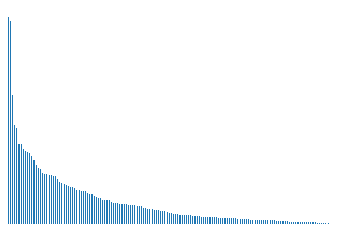

In [ ]:
# Distribution of data among the category
df_train['category'].value_counts().plot(kind='bar')
plt.axis('off')
plt.show()

In [ ]:
df_train['category'].value_counts()

cs-LG        23414
cs-CV        22943
quant-ph-    14561
cs-CL        11143
hep-ph-      10863
             ...  
q-fin-EC        17
astro-ph-        7
q-alg-           2
alg-geom-        1
funct-an-        1
Name: category, Length: 156, dtype: int64

**Observation**:
The class is highly imbalanced and there are few classes which has very few records


### Data Preprocessing

In [ ]:
ps = PorterStemmer()

In [ ]:
def clean_abstract(text):
  text = re.sub('[^a-z\s]', ' ', text.lower())
  text = [i.lower() for i in text.split() if i not in nlp.Defaults.stop_words]
  text = map(ps.stem, text)
  text = ' '.join(text)
  text.replace('\n',' ')
  return text

In [ ]:
df_train['abstract'] = df_train['abstract'].apply(clean_abstract)

In [ ]:
df_test['abstract'] = df_test['abstract'].apply(clean_abstract)

In [ ]:
df_test1['abstract'] = df_test1['abstract'].apply(clean_abstract)

In [ ]:
df_train.to_csv("prepro_train.csv", index=False)

In [ ]:
df_test.to_csv("prepro_val.csv", index=False)

In [ ]:
df_test1.to_csv("prepro_test.csv", index=False)

In [ ]:
# df_train_new = pd.read_csv('preprocessed_train.csv')
# df_validation_new = pd.read_csv('preprocessed_val.csv')
# df_test_new = pd.read_csv('preprocessed_test.csv')

##### Text vectorization

In [ ]:
X_train, y_train = df_train['abstract'],df_train['category_num']
X_test, y_test = df_test['abstract'],df_test['category_num']

In [ ]:
X_test1 = df_test1['abstract']

In [ ]:
#df_test1=df_test1.drop(columns=["abstract","Prediction"])

In [ ]:
# label_encoder = LabelEncoder().fit(y_train)

# y_train = label_encoder.transform(y_train)
# y_test = label_encoder.transform(y_test)

In [ ]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))

In [ ]:
tfidf_vectorizer = tfidf.fit(X_train)

X_train = tfidf_vectorizer.transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [ ]:
X_test1 = tfidf_vectorizer.transform(X_test1)

### Classification using under sampling and over sampling

In [ ]:
svc_s = LinearSVC(max_iter=1000)

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
def sampling_strategy(y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = {k:v for k,v in dict(Counter(y)).items() if v > n_samples}
    elif t == 'minority':
        # Since SMOTE depends on KNN, filtering out those samples that occur less than 10 times
        target_classes = {k:v for k,v in dict(Counter(y)).items() if v < n_samples and v > 10}
    sampling_strategy = {k:n_samples for k,v in target_classes.items()}
    return sampling_strategy

In [ ]:
over_sampler_ss = sampling_strategy(y_train,1000,t='minority')

In [ ]:
under_sampler_ss = sampling_strategy(y_train,8000,t='majority')

In [ ]:
over = SMOTE(sampling_strategy=over_sampler_ss)

In [ ]:
under = RandomUnderSampler(sampling_strategy=under_sampler_ss, random_state=42)

In [ ]:
X_over, y_over = over.fit_resample(X_train, y_train)

In [ ]:
X_under, y_under = under.fit_resample(X_train, y_train)

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

# nb = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('clf', MultinomialNB()),
#               ])
# nb.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import classification_report, accuracy_score
# y_pred = nb.predict(X_test)

In [ ]:
# y_pred1=nb.predict(X_test1)

In [ ]:
# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred))

In [ ]:
print(svc_s.__class__.__name__)
svc_s.fit(X_under, y_under)
y_pred = svc_s.predict(X_test)

LinearSVC


In [ ]:
y_pred1 = svc_s.predict(X_test1)

In [ ]:
f1_score(y_test, y_pred, average='macro')

0.5062977547055801

In [ ]:
df_test1['category_num']=y_pred1

In [ ]:
df_test1.head()

,id,abstract,category_num
0,430065,depth map obtain commerci depth sensor low res...,25
1,75226,lambda express introduc java program languag r...,54
2,301990,propos demonstr gamma gamma collid w gg gev ad...,68
3,301001,physic lab student experi wide rang equit ineq...,118
4,280179,exist local minima hidden layer relu network i...,40


In [ ]:
df_test1.to_csv("solution.csv", index=False)

In [ ]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)

In [ ]:
rbf_pred = rbf.predict(X_test)

In [ ]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

In [ ]:
# poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

In [ ]:
poly_pred = poly.predict(X_test)

In [ ]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))